In [1]:
import torch
import torch.nn as nn
from torchvision.models import alexnet
from torchvision.models import vgg11
from torchvision.models import googlenet
from torchvision.models import resnet18
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
import torchvision.transforms as T
from torch.optim import Adam
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.optim import AdamW

In [2]:
dataset_train = CIFAR10('../lesson4/data/', train=True, download=True)

means = (dataset_train.data / 255).mean(axis=(0, 1, 2))
stds = (dataset_train.data / 255).std(axis=(0, 1, 2))

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name())

Files already downloaded and verified
cuda:0
NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:

from tqdm import tqdm


def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()
        
        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [4]:

@torch.inference_mode()
def evaluate(model, loader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [5]:

from IPython.display import clear_output

def plot_stats(
    train_loss,
    valid_loss,
    train_accuracy,
    valid_accuracy,
    title,
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')
    
    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [6]:

def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )
        
        if valid_accuracy >= 0.905:
            break

In [7]:

def get_pretrained_model(model_name: str, num_classes: int, pretrained: bool = True):

    if model_name == 'resnet18':

        model = resnet18(pretrained=pretrained)
        model.fc = nn.Linear(in_features=512, out_features=num_classes)

    elif model_name == 'alexnet':

        model = alexnet(pretrained=pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    elif model_name == 'vgg11':

        model = vgg11(pretrained=pretrained)
        model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)

    elif model_name == 'googlenet':
        
        if pretrained:
            
            model = googlenet(pretrained=pretrained)
            model.fc = nn.Linear(in_features=1024, out_features=num_classes)
            
        else:
            
            model = googlenet(pretrained=pretrained)
            model.aux1.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
            model.aux2.fc2 = nn.Linear(in_features=1024, out_features=num_classes)
            model.fc = nn.Linear(in_features=1024, out_features=num_classes)

    return model


In [8]:

def predict_tta(model: nn.Module, loader: DataLoader, device: torch.device, iterations: int = 2):
    model.eval()

    prediction = []
    
    for i in range(iterations):
        
        single_prediction = []
        
        with torch.no_grad():
            
            for x,y in loader:
                
                x,y = x.to(device), y.to(device)
                output = model(x)
                single_prediction.append(output)
        prediction.append(torch.vstack(single_prediction))
        
    result = torch.stack(prediction).mean(dim=0)
    
    return torch.argmax(result, dim=1)




In [9]:
def whole_train_valid_cycle_with_schedule(model, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []
    
    valid_accuracy = 0
    num_epochs = 0
    

    while valid_accuracy < 0.93 and num_epochs < 30:
        
        num_epochs += 1 
        
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            f'{title}, {num_epochs} epoch'
        )
        
        scheduler.step()

In [10]:
import torch.nn as nn

class Model_With_SkipConn(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out


In [11]:
train_transforms = T.Compose(
    [
        T.RandomResizedCrop(size=32, scale=(0.8, 1.1)),
        T.RandomHorizontalFlip(p=0.5),
        T.RandomAdjustSharpness(sharpness_factor=2),
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)

test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Normalize(mean=means, std=stds)
    ]
)


In [12]:
train_dataset = CIFAR10('../lesson4/data/', train=True, transform=train_transforms)
valid_dataset = CIFAR10('../lesson4/data/', train=False, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [13]:
model = Model_With_SkipConn().to(device)

optimizer = AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=25)

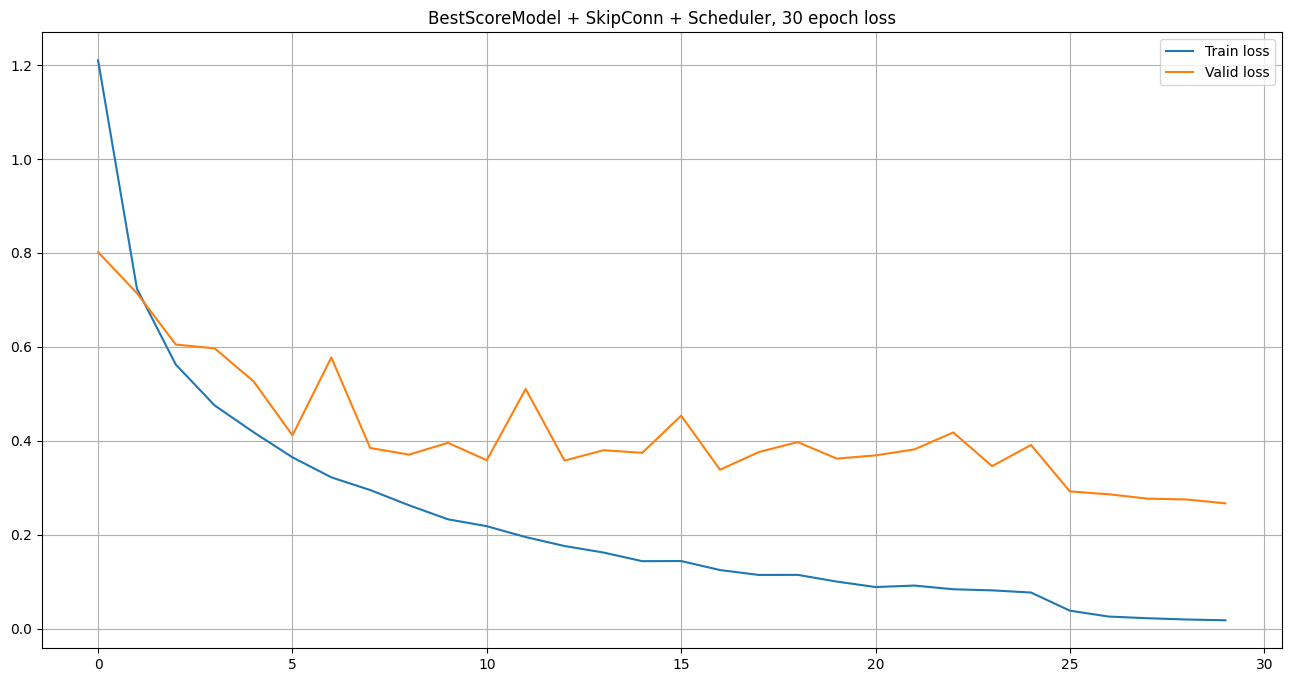

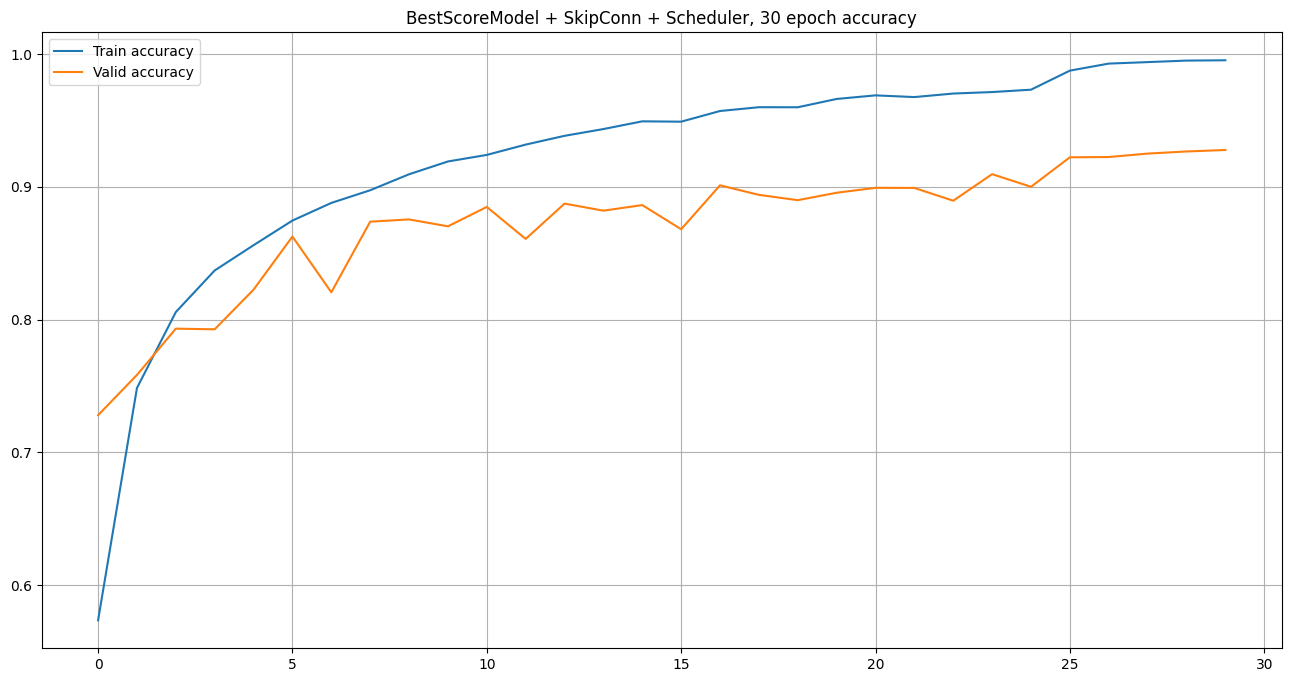

In [14]:
whole_train_valid_cycle_with_schedule(model,'BestScoreModel + SkipConn + Scheduler')

In [15]:
model.eval()
valid_loss, valid_accuracy = evaluate(model, valid_loader)
print(f'Validation accuracy: {valid_accuracy*100:.2f}%')


Evaluation: 100%|██████████| 79/79 [00:06<00:00, 11.52it/s]

Validation accuracy: 92.78%


In [16]:
# Step 1: Get Predictions
predictions = predict_tta(model, valid_loader, device)

# Step 2: Save Predictions
torch.save(predictions, 'predictions_improve.pt')

# Load the saved predictions
predictions = torch.load('predictions_improve.pt')

# Use the loaded predictions
print(predictions)


tensor([3, 8, 8,  ..., 5, 1, 7], device='cuda:0')
